<a href="https://colab.research.google.com/github/ayushpatra11/CV_CW/blob/main/Computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install opencv-python numpy scikit-learn matplotlib

In [1]:
import numpy as np
import cv2 as cv
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.datasets import cifar10, cifar100

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

def resize_images(images, target_size=(128, 128)):
  return np.array([cv.resize(img, target_size) for img in images])

x_train_resized = resize_images(x_train)
x_test_resized = resize_images(x_test)

x_train_resized = x_train_resized[:5000]
x_test_resized = x_test_resized[:200]
y_train = y_train[:5000].flatten()
y_test = y_test[:200].flatten()


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


In [5]:
from sklearn.preprocessing import normalize
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
import numpy as np
import cv2



def run_bow_svm_experiment(k_clusters=100, svm_kernel='linear', C=1.0):
    # Create SIFT detector
    sift = cv2.SIFT_create()
    descriptors_list = []

    for img in x_train_resized:
        kp, des = sift.detectAndCompute(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), None)
        if des is not None:
            descriptors_list.append(des)

    all_desc = np.vstack(descriptors_list)
    kmeans = KMeans(n_clusters=k_clusters, random_state=42)
    kmeans.fit(all_desc)

    def compute_bow_histogram(image):
        kp, des = sift.detectAndCompute(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), None)
        if des is None:
            return np.zeros(k_clusters)
        cluster_result = kmeans.predict(des)
        hist, _ = np.histogram(cluster_result, bins=np.arange(k_clusters + 1))
        return hist

    X_train_bow = np.array([compute_bow_histogram(img) for img in x_train_resized])
    X_test_bow = np.array([compute_bow_histogram(img) for img in x_test_resized])

    # Normalize
    X_train_bow = normalize(X_train_bow, norm='l2')
    X_test_bow = normalize(X_test_bow, norm='l2')

    # Train SVM
    svm = SVC(kernel=svm_kernel, C=C)
    svm.fit(X_train_bow, y_train)
    y_pred = svm.predict(X_test_bow)
    acc = accuracy_score(y_test, y_pred)
    print(f"k={k_clusters}, kernel={svm_kernel}, C={C} → Accuracy: {acc:.4f}")
    return svm, kmeans, acc

In [28]:
import joblib
import numpy as np
best_acc = 0
best_params = None
results = []
for k in [10, 20, 30, 50, 75, 100, 150, 200, 300]:
    for kernel in ['linear', 'rbf']:
        for C in [0.1, 1]:
            svm, kmeans, acc = run_bow_svm_experiment(k_clusters=k, svm_kernel=kernel, C=C)
            if acc > best_acc:
                best_acc = acc
                joblib.dump(svm, "best_svm_bow_model.pkl")
                joblib.dump(kmeans, "best_kmeans_vocab.pkl")
                print(f"Saved new best model with acc={acc:.4f}")
            results.append((k, kernel, C, acc))

k=10, kernel=linear, C=0.1 → Accuracy: 0.1850
k=10, kernel=linear, C=1 → Accuracy: 0.1950
k=10, kernel=rbf, C=0.1 → Accuracy: 0.1900
k=10, kernel=rbf, C=1 → Accuracy: 0.2200
k=20, kernel=linear, C=0.1 → Accuracy: 0.2400
k=20, kernel=linear, C=1 → Accuracy: 0.2300
k=20, kernel=rbf, C=0.1 → Accuracy: 0.2350
k=20, kernel=rbf, C=1 → Accuracy: 0.2100
k=30, kernel=linear, C=0.1 → Accuracy: 0.2450
k=30, kernel=linear, C=1 → Accuracy: 0.2500
k=30, kernel=rbf, C=0.1 → Accuracy: 0.2400
k=30, kernel=rbf, C=1 → Accuracy: 0.2200
k=50, kernel=linear, C=0.1 → Accuracy: 0.2250
k=50, kernel=linear, C=1 → Accuracy: 0.2400
k=50, kernel=rbf, C=0.1 → Accuracy: 0.2200
k=50, kernel=rbf, C=1 → Accuracy: 0.2250
k=75, kernel=linear, C=0.1 → Accuracy: 0.2850
Saved new best model with acc=0.2850
k=75, kernel=linear, C=1 → Accuracy: 0.2300
k=75, kernel=rbf, C=0.1 → Accuracy: 0.2300
k=75, kernel=rbf, C=1 → Accuracy: 0.2600
k=100, kernel=linear, C=0.1 → Accuracy: 0.2550
k=100, kernel=linear, C=1 → Accuracy: 0.2300
k

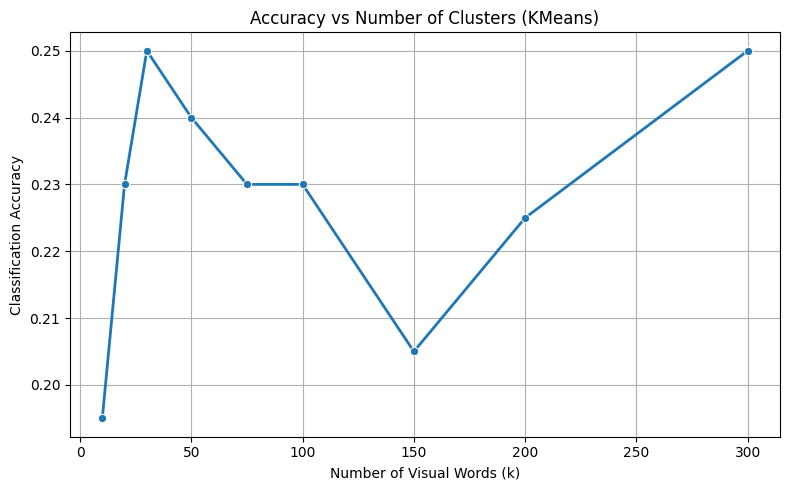

In [29]:
import pandas as pd

# results list contains (k, kernel, C, acc) tuples
# DataFrame needs matching columns
df_elbow = pd.DataFrame(results, columns=["k", "kernel", "C", "Accuracy"])

import matplotlib.pyplot as plt
import seaborn as sns

# Plotting Accuracy vs. k, you'll need to select data for a specific kernel and C
# For example, plotting for kernel='linear', C=1:
selected_data = df_elbow[(df_elbow['kernel'] == 'linear') & (df_elbow['C'] == 1)]

plt.figure(figsize=(8, 5))
sns.lineplot(data=selected_data, x="k", y="Accuracy", marker="o", linewidth=2)
plt.title("Accuracy vs Number of Clusters (KMeans)")
plt.xlabel("Number of Visual Words (k)")
plt.ylabel("Classification Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

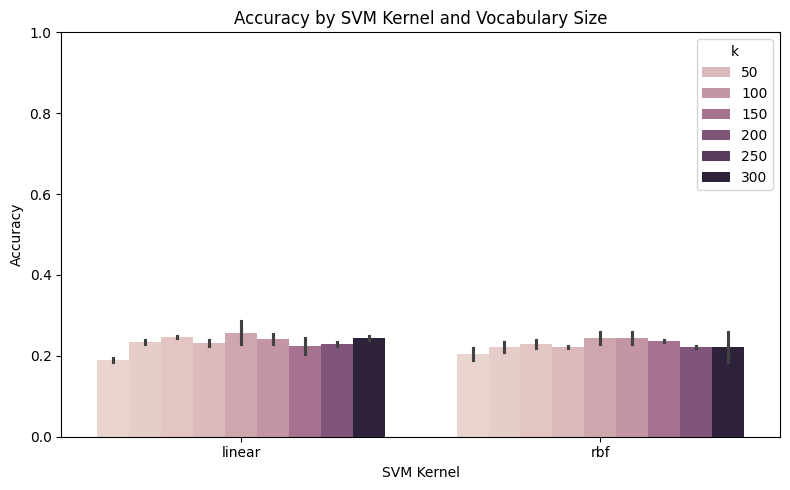

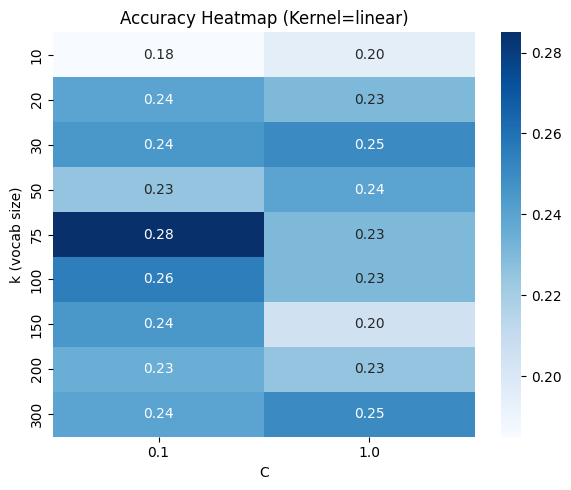

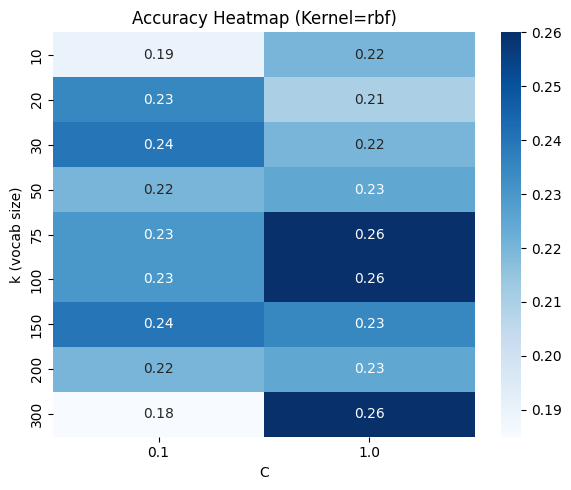

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(results, columns=["k", "kernel", "C", "Accuracy"])

# Bar plot
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="kernel", y="Accuracy", hue="k")
plt.title("Accuracy by SVM Kernel and Vocabulary Size")
plt.xlabel("SVM Kernel")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend(title="k")
plt.tight_layout()
plt.show()

# Accuracy heatmap for each kernel
for kern in df['kernel'].unique():
    pivot = df[df['kernel'] == kern].pivot(index='k', columns='C', values='Accuracy')
    plt.figure(figsize=(6, 5))
    sns.heatmap(pivot, annot=True, cmap='Blues', fmt=".2f")
    plt.title(f"Accuracy Heatmap (Kernel={kern})")
    plt.xlabel("C")
    plt.ylabel("k (vocab size)")
    plt.tight_layout()
    plt.show()

In [31]:

# Initialize SIFT detector
sift = cv2.SIFT_create()
def compute_bow_histogram(image, sift, kmeans, k):
    kp, des = sift.detectAndCompute(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), None)
    if des is None:
        return np.zeros(k)
    cluster_result = kmeans.predict(des)
    hist, _ = np.histogram(cluster_result, bins=np.arange(k + 1))
    return hist

# Create histograms for test data
best_kmeans = joblib.load("best_kmeans_vocab.pkl")
k = best_kmeans.n_clusters
X_test_bow = np.array([compute_bow_histogram(img, sift, kmeans, k) for img in x_test_resized])

from sklearn.preprocessing import normalize
X_test_bow = normalize(X_test_bow, norm='l2')

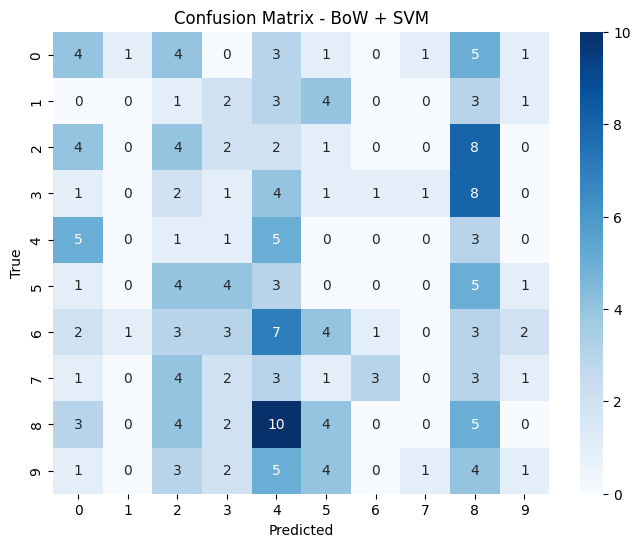

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix - BoW + SVM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

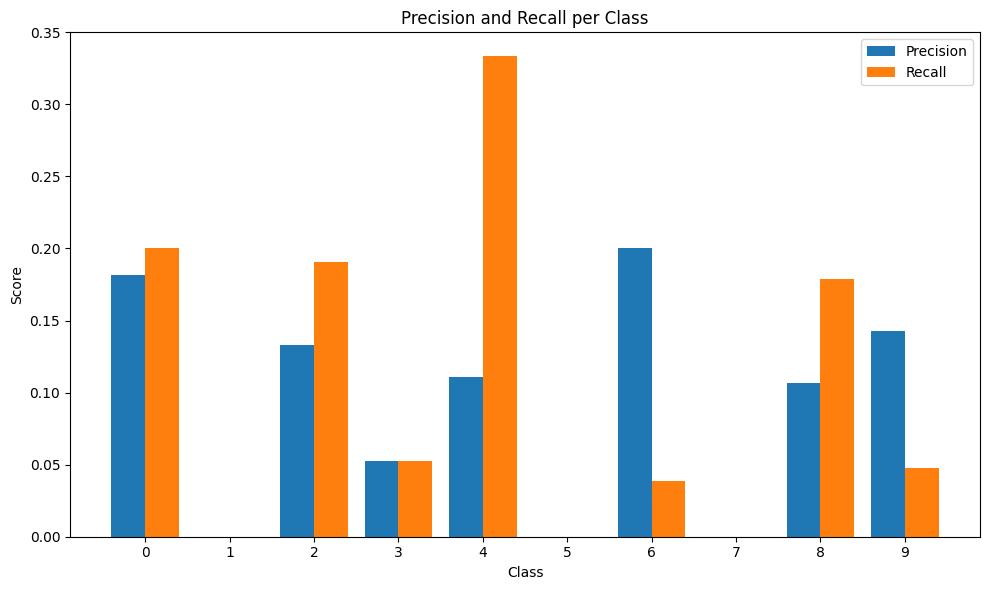

In [37]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred)
x = np.arange(len(classes))

plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, precision, width=0.4, label='Precision')
plt.bar(x + 0.2, recall, width=0.4, label='Recall')
plt.xticks(x, classes)
plt.title("Precision and Recall per Class")
plt.xlabel("Class")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()

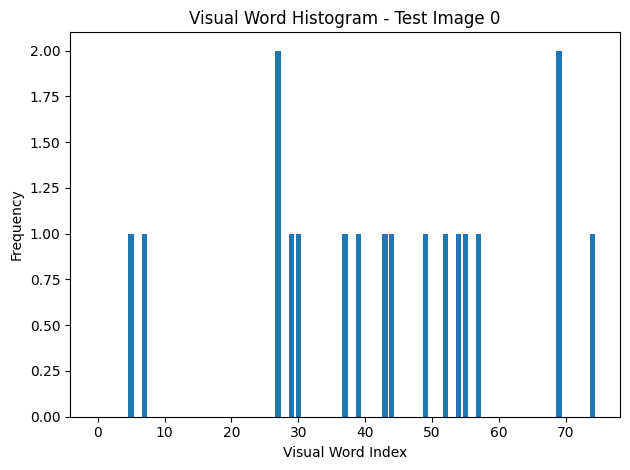

In [38]:
idx = 0
hist = compute_bow_histogram(x_test_resized[idx], sift, kmeans, k)

plt.bar(range(k), hist)
plt.title(f"Visual Word Histogram - Test Image {idx}")
plt.xlabel("Visual Word Index")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [4]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

classes = trainset.classes
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# subset_size = 5000
# trainset = torch.utils.data.Subset(trainset, range(subset_size))
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
import torchvision.models as models

mobilenet = models.mobilenet_v3_large(pretrained=True)

# Freeze most layers
for param in mobilenet.features[:14].parameters():
    param.requires_grad = False
# Unfreeze deeper layers
for param in mobilenet.features[14:].parameters():
    param.requires_grad = True

mobilenet.classifier[3] = nn.Sequential(
    nn.Linear(mobilenet.classifier[3].in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.6),  # stronger dropout
    nn.Linear(256, 10)
)

mobilenet = mobilenet.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 70.5MB/s]


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilenet.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [7]:
num_epochs = 10
train_acc_list = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct, total = 0, 0
    mobilenet.train()

    print(f"\nEpoch {epoch+1}/{num_epochs} started...")

    for i, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = mobilenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print progress every 100 batches
        if (i + 1) % 100 == 0 or (i + 1) == len(trainloader):
            print(f"  Batch {i+1}/{len(trainloader)} - Loss: {loss.item():.4f}")
    scheduler.step()

    acc = correct / total
    train_acc_list.append(acc)
    print(f"Epoch {epoch+1} completed — Loss: {running_loss:.3f}, Accuracy: {acc:.4f}")


Epoch 1/10 started...
  Batch 100/782 - Loss: 0.7732
  Batch 200/782 - Loss: 0.4593
  Batch 300/782 - Loss: 0.5565
  Batch 400/782 - Loss: 0.4381
  Batch 500/782 - Loss: 0.3820
  Batch 600/782 - Loss: 0.5957
  Batch 700/782 - Loss: 0.6065
  Batch 782/782 - Loss: 0.4687
Epoch 1 completed — Loss: 559.435, Accuracy: 0.7625

Epoch 2/10 started...
  Batch 100/782 - Loss: 0.8938
  Batch 200/782 - Loss: 0.5822
  Batch 300/782 - Loss: 0.4925
  Batch 400/782 - Loss: 0.3244
  Batch 500/782 - Loss: 0.3263
  Batch 600/782 - Loss: 0.5039
  Batch 700/782 - Loss: 0.4463
  Batch 782/782 - Loss: 0.3103
Epoch 2 completed — Loss: 303.596, Accuracy: 0.8692

Epoch 3/10 started...
  Batch 100/782 - Loss: 0.2445
  Batch 200/782 - Loss: 0.3734
  Batch 300/782 - Loss: 0.2375
  Batch 400/782 - Loss: 0.2191
  Batch 500/782 - Loss: 0.4617
  Batch 600/782 - Loss: 0.2435
  Batch 700/782 - Loss: 0.4096
  Batch 782/782 - Loss: 0.5048
Epoch 3 completed — Loss: 253.163, Accuracy: 0.8917

Epoch 4/10 started...
  Batch 

In [8]:
mobilenet.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        outputs = mobilenet(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Test Accuracy:", accuracy_score(all_labels, all_preds))
print(classification_report(all_labels, all_preds, target_names=classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - MobileNetV3 Large')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Test Accuracy: 0.9245
              precision    recall  f1-score   support

    airplane       0.93      0.93      0.93      1000
  automobile       0.95      0.97      0.96      1000
        bird       0.93      0.90      0.92      1000
         cat       0.83      0.85      0.84      1000
        deer       0.91      0.92      0.92      1000
         dog       0.85      0.90      0.88      1000
        frog       0.97      0.94      0.95      1000
       horse       0.96      0.95      0.95      1000
        ship       0.97      0.94      0.95      1000
       truck       0.96      0.94      0.95      1000

    accuracy                           0.92     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.93      0.92      0.92     10000



NameError: name 'plt' is not defined